# Libraries

In [1]:
# Basic Libraries
import os
import git

# Data Manipulation
import pandas as pd
import numpy as np

# set the display option to show all columns
pd.set_option("display.max_columns", None)

# Machine Learning
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix
from sklearn import tree


# Weka libraries
import weka.core.jvm as jvm
from weka.core.converters import Loader
from weka.classifiers import Classifier, Evaluation
from weka.core.classes import Random

# Data visualization
import graphviz
import matplotlib.pyplot as plt
import seaborn as sns

# Functions

In [2]:
# Função para encontrar diretório do repositório git
def get_git_root(path: str) -> str:
    git_repo = git.Repo(path, search_parent_directories=True)
    git_root = git_repo.git.rev_parse("--show-toplevel")
    return git_root


def encode_categorical(df: pd.DataFrame) -> pd.DataFrame:
    """
    Converte atributos numéricos discretos de um DataFrame

    :param df: DataFrame do Pandas para conversão
    """
    # Instanciar um objeto LabelEncoder
    le = LabelEncoder()

    # Iterar sobre todas as colunas do DataFrame
    for col in df.columns:
        # Verificar se a coluna é do tipo "object", o que geralmente indica
        # uma coluna categórica com strings
        if df[col].dtype == "object":
            # Se for uma coluna categórica, use o LabelEncoder para ajustar
            # e transformar os dados, substituindo os valores originais
            # pelos valores codificados como números inteiros
            df[col] = le.fit_transform(df[col])

    # Retornar o DataFrame com as colunas categóricas codificadas
    return df


def pandas2arff(
    df, filename, wekaname="pandasdata", cleanstringdata=True, cleannan=True
):
    """
    converts the pandas dataframe to a weka compatible file
    df: dataframe in pandas format
    filename: the filename you want the weka compatible file to be in
    wekaname: the name you want to give to the weka dataset (this will be visible to you when you open it in Weka)
    cleanstringdata: clean up data which may have spaces and replace with "_", special characters etc which seem to annoy Weka.
                     To suppress this, set this to False
    cleannan: replaces all nan values with "?" which is Weka's standard for missing values.
              To suppress this, set this to False
    """
    import re

    def cleanstring(s):
        if s != "?":
            return re.sub("[^A-Za-z0-9]+", "_", str(s))
        else:
            return "?"

    dfcopy = df  # all cleaning operations get done on this copy

    if cleannan != False:
        dfcopy = dfcopy.fillna(
            -999999999
        )  # this is so that we can swap this out for "?"
        # this makes sure that certain numerical columns with missing values don't get stuck with "object" type

    # Diretório do repositório git
    git_dir = get_git_root(os.getcwd())

    # Diretório de arquivos de dados
    data_dir = os.path.join(git_dir, "data")

    f = open(os.path.join(data_dir, filename), "w")
    arffList = []
    arffList.append("@relation " + wekaname + "\n")
    # look at each column's dtype. If it's an "object", make it "nominal" under Weka for now (can be changed in source for dates.. etc)
    for i in range(df.shape[1]):
        if dfcopy.dtypes[i] == "O" or (df.columns[i] in ["Class", "CLASS", "class"]):
            if cleannan != False:
                dfcopy.iloc[:, i] = dfcopy.iloc[:, i].replace(
                    to_replace=-999999999, value="?"
                )
            if cleanstringdata != False:
                dfcopy.iloc[:, i] = dfcopy.iloc[:, i].apply(cleanstring)
            _uniqueNominalVals = [str(_i) for _i in np.unique(dfcopy.iloc[:, i])]
            _uniqueNominalVals = ",".join(_uniqueNominalVals)
            _uniqueNominalVals = _uniqueNominalVals.replace("[", "")
            _uniqueNominalVals = _uniqueNominalVals.replace("]", "")
            _uniqueValuesString = "{" + _uniqueNominalVals + "}"
            arffList.append("@attribute " + df.columns[i] + _uniqueValuesString + "\n")
        else:
            arffList.append("@attribute " + df.columns[i] + " real\n")
            # even if it is an integer, let's just deal with it as a real number for now
    arffList.append("@data\n")
    for i in range(dfcopy.shape[0]):  # instances
        _instanceString = ""
        for j in range(df.shape[1]):  # features
            if dfcopy.dtypes[j] == "O":
                _instanceString += '"' + str(dfcopy.iloc[i, j]) + '"'
            else:
                _instanceString += str(dfcopy.iloc[i, j])
            if j != dfcopy.shape[1] - 1:  # if it's not the last feature, add a comma
                _instanceString += ","
        _instanceString += "\n"
        if cleannan != False:
            _instanceString = _instanceString.replace(
                "-999999999.0", "?"
            )  # for numeric missing values
            _instanceString = _instanceString.replace(
                '"?"', "?"
            )  # for categorical missing values
        arffList.append(_instanceString)
    f.writelines(arffList)
    f.close()
    del dfcopy
    return True

# Data Load

In [3]:
# Diretório do repositório git
git_dir = get_git_root(os.getcwd())

# Diretório dos dados
data_dir = os.path.join(git_dir, "data")

# Leitura dos arquivos de treinamento e teste
df_train = pd.read_csv(os.path.join(data_dir, "train.csv"))
test_input = pd.read_csv(os.path.join(data_dir, "test.csv"))
sample_output = pd.read_csv(os.path.join(data_dir, "sample_submission.csv"))

# merge entre dataframes
df_test = pd.merge(test_input, sample_output, how="inner", on="Id")


In [4]:
# carregando os datos de treinamento e validação 
train = df_train.copy()
test = df_test.copy()

# Classification Analysis

## Data treatment and cleaning

In [5]:
# Calcular a porcentagem de valores ausentes em cada coluna com valores ausentes maiores que 0
missing_data = train.isnull().sum()[train.isnull().sum() > 0]
missing_data_percentage = missing_data / len(train) * 100

# Combinar as informações em um dataframe
missing_data_df = pd.concat(
    [missing_data, missing_data_percentage], axis=1, keys=["Total", "Percentage"]
)

# Ordenar os valores pela porcentagem de valores ausentes em ordem decrescente
missing_data_df = missing_data_df.sort_values(by="Percentage", ascending=False)

missing_data_df

,Total,Percentage
PoolQC,1453,99.520548
MiscFeature,1406,96.301370
Alley,1369,93.767123
Fence,1179,80.753425
MasVnrType,872,59.726027
FireplaceQu,690,47.260274
LotFrontage,259,17.739726
GarageType,81,5.547945
GarageYrBlt,81,5.547945
GarageFinish,81,5.547945


In [6]:
# Lista de colunas que precisam ser preenchidas com "NA"
cols_to_fillna = [
    "PoolQC",
    "MiscFeature",
    "Alley",
    "Fence",
    "FireplaceQu",
    "GarageType",
    "GarageFinish",
    "GarageQual",
    "GarageCond",
    "BsmtExposure",
    "BsmtFinType2",
    "BsmtFinType1",
    "BsmtCond",
    "BsmtQual",
]

# Usando uma compreensão de lista para preencher os valores ausentes com "NA" em cada coluna
for col in cols_to_fillna:
    train[col].fillna("NA", inplace=True)

# Preenchendo os valores ausentes no atributo "LotFrontage" com o valor padrão "0"
train["LotFrontage"].fillna(0, inplace=True)

# Preenchendo os valores ausentes no atributo "GarageYrBlt" com o valor padrão "0"
train["GarageYrBlt"].fillna(0, inplace=True)

# Excluindo as instâncias com valores ausentes (conjunto pequeno em relação ao tamanho do conjunto de dados)
cols_to_dropna = ["MasVnrType", "MasVnrArea", "Electrical"]
train.dropna(subset=cols_to_dropna, inplace=True)

In [7]:
# retirar a coluna id
test.drop(
    columns=["Id"], inplace=True
)

In [8]:
# Chamando a função encode_categorical() para aplicar LabelEncoder em variáveis categóricas
train = encode_categorical(train)

In [9]:
# Calcular a porcentagem de valores ausentes em cada coluna com valores ausentes maiores que 0
missing_data = test.isnull().sum()[test.isnull().sum() > 0]
missing_data_percentage = missing_data / len(test) * 100

# Combinar as informações em um dataframe
missing_data_df = pd.concat(
    [missing_data, missing_data_percentage], axis=1, keys=["Total", "Percentage"]
)

# Ordenar os valores pela porcentagem de valores ausentes em ordem decrescente
missing_data_df = missing_data_df.sort_values(by="Percentage", ascending=False)

missing_data_df

,Total,Percentage
PoolQC,1456,99.794380
MiscFeature,1408,96.504455
Alley,1352,92.666210
Fence,1169,80.123372
MasVnrType,894,61.274846
FireplaceQu,730,50.034270
LotFrontage,227,15.558602
GarageCond,78,5.346127
GarageYrBlt,78,5.346127
GarageQual,78,5.346127


In [10]:
# Lista de colunas que precisam ser preenchidas com "NA"
cols_to_fillna = [
    "PoolQC",
    "MiscFeature",
    "Alley",
    "Fence",
    "FireplaceQu",
    "GarageType",
    "GarageFinish",
    "GarageQual",
    "GarageCond",
    "BsmtExposure",
    "BsmtFinType2",
    "BsmtFinType1",
    "BsmtCond",
    "BsmtQual",
]

# Usando uma compreensão de lista para preencher os valores ausentes com "NA" em cada coluna
for col in cols_to_fillna:
    test[col].fillna("NA", inplace=True)

test["MasVnrType"].fillna("None", inplace=True)

# Preenchendo os valores ausentes no atributo "LotFrontage" com o valor padrão "0"
test["LotFrontage"].fillna(0, inplace=True)

# Preenchendo os valores ausentes no atributo "GarageYrBlt" com o valor padrão "0"
test["GarageYrBlt"].fillna(0, inplace=True)

# Preenchendo os valores ausentes no atributo "MasVnrArea" com o valor padrão "0"
test["MasVnrArea"].fillna(0, inplace=True)

# Excluindo as instâncias com valores ausentes (conjunto pequeno em relação ao tamanho do conjunto de dados)
cols_to_dropna = [
    "MSZoning",
    "BsmtFullBath",
    "BsmtHalfBath",
    "Functional",
    "Utilities",
    "GarageCars",
    "GarageArea",
    "TotalBsmtSF",
    "KitchenQual",
    "BsmtUnfSF",
    "BsmtFinSF2",
    "BsmtFinSF1",
    "Exterior2nd",
    "Exterior1st",
]
test.dropna(subset=cols_to_dropna, inplace=True)

In [11]:
# retirar a coluna id
train.drop(
    columns=["Id"], inplace=True
)

In [12]:
# Chamando a função encode_categorical() para aplicar LabelEncoder em variáveis categóricas
test = encode_categorical(test)

## Discretizer Sale Price

In [13]:
target_variable = "SalePrice"

# Ajustar e transformar os dados de treinamento e teste com MinMaxScaler
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train[[target_variable]])
test_scaled = scaler.transform(test[[target_variable]])

# Instanciar a classe KBinsDiscretizer com 5 bins (faixas)
discretizer = KBinsDiscretizer(n_bins=5, encode="ordinal", strategy="quantile")

# Aplicar o discretizer nos dados 'SalePrice' escalonados
train_preco_discretizado = discretizer.fit_transform(train_scaled)
test_preco_discretizado = discretizer.transform(test_scaled)

# Adicionar a nova coluna de categorias ao dataframe original
train["SalePriceCategorical"] = pd.Series(train_preco_discretizado.reshape(-1))
test["SalePriceCategorical"] = pd.Series(test_preco_discretizado.reshape(-1))

target_variable = "SalePriceCategorical"

# Renomear as categorias
train[target_variable].replace(
    {
        0: "House Price 1",
        1: "House Price 2",
        2: "House Price 3",
        3: "House Price 4",
        4: "House Price 5",
    },
    inplace=True,
)
test[target_variable].replace(
    {
        0: "House Price 1",
        1: "House Price 2",
        2: "House Price 3",
        3: "House Price 4",
        4: "House Price 5",
    },
    inplace=True,
)

train.dropna(inplace=True)
test.dropna(inplace=True)

## Standard Data

In [14]:
# Padronizar as entradas do modelo
# Criar um objeto StandardScaler
scaler = StandardScaler()

# retirar a coluna SalePrice
train.drop(columns="SalePrice", inplace=True)
test.drop(columns="SalePrice", inplace=True)

# Padronizar todo o dataframe
X_train = scaler.fit_transform(train.drop(target_variable, axis=1))
X_test = scaler.fit_transform(test.drop(target_variable, axis=1))

In [15]:
# Separar as variáveis de entrada (features) e o target
y_train = train[target_variable]
y_test = test[target_variable]

## Decision tree classifier

In [16]:
# Instanciar o classificador DecisionTreeClassifier com os parâmetros padrão
classifier = DecisionTreeClassifier(criterion="entropy")

# Treinar o classificador com os dados de treinamento
classifier.fit(X_train, y_train)

# Realizar as predições com os dados de teste
y_pred = classifier.predict(X_test)

# Avaliar a precisão do modelo
accuracy = classifier.score(X_test, y_test)
print("A precisão do modelo é: {:.2f}%".format(accuracy * 100))

A precisão do modelo é: 25.82%


In [17]:
# Questão 1)
feature_names = train.drop(columns=target_variable).columns
class_names = train[target_variable].unique()

# Criar uma representação em DOT da árvore de decisão
dot_data = tree.export_graphviz(
    classifier,
    out_file=None,
    feature_names=feature_names,
    class_names=class_names,
    filled=True,
    rounded=True,
    special_characters=True,
)

# Diretório do repositório git
git_dir = get_git_root(os.getcwd())

# Diretório de arquivos de saída
output_dir = os.path.join(git_dir, "output")

# Renderizar a árvore de decisão usando o Graphviz
graph = graphviz.Source(dot_data)
graph.render("decision_tree", directory=output_dir, format="pdf", cleanup=True)

# Abre a imagem da árvore de decisão gerada
# graph.view()

'C:\\Users\\Vinícius Parede\\Documents\\repositories\\house-prices-prediction-ppgia\\output\\decision_tree.pdf'

In [18]:
# Questão 3)
from sklearn.model_selection import cross_val_score

# Definir o número de folds para a validação cruzada
cv_folds = 10

# Calcular a taxa de acerto usando validação cruzada com 10 folds
scores = cross_val_score(classifier, X_test, y_test, cv=cv_folds, scoring='accuracy')

# Calcular a média das taxas de acerto de cada fold
average_accuracy = scores.mean()

# Imprimir a taxa média de acerto
print("A taxa média de acerto utilizando o método de validação cruzada com {} folds é: {:.2f}%".format(cv_folds, average_accuracy * 100))


A taxa média de acerto utilizando o método de validação cruzada com 10 folds é: 47.74%


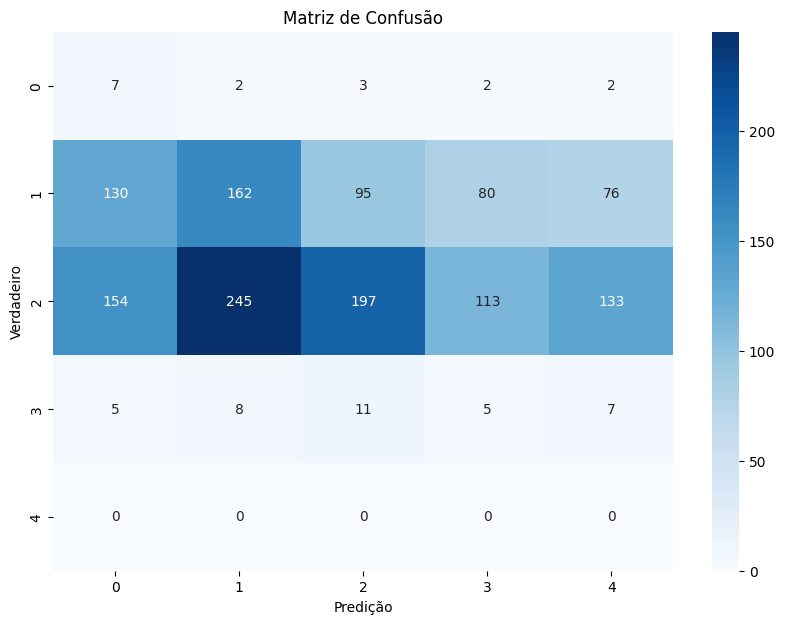

In [19]:
# Questao 4) 

# Calcular a matriz de confusão
conf_matrix = confusion_matrix(y_test, y_pred)

# Criar um gráfico de heatmap com a matriz de confusão
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predição')
plt.ylabel('Verdadeiro')
plt.title('Matriz de Confusão')
plt.show()

## ARFF Files - Use in Weka

In [20]:
# converter dataframe pandas para arquivo arff
pandas2arff(train, "train.arff", wekaname="train_data")
pandas2arff(test, "test.arff", wekaname="test_data")

True

In [21]:
# Inicializar JVM
jvm.start()

# Diretório do repositório git
git_dir = get_git_root(os.getcwd())

# Diretório de arquivos de saída
output_dir = os.path.join(git_dir, "output")

# Carregar o conjunto de dados
loader = Loader("weka.core.converters.ArffLoader")
train_data = loader.load_file(os.path.join(output_dir, "train.arff"))
test_data = loader.load_file(os.path.join(output_dir, "test.arff"))

# usado para informar ao Weka que a classe dependente é a última coluna do conjunto de dados
train_data.class_is_last()
test_data.class_is_last()

DEBUG:weka.core.jvm:Adding bundled jars
DEBUG:weka.core.jvm:Classpath=['C:\\Users\\Vinícius Parede\\Documents\\repositories\\house-prices-prediction-ppgia\\.env\\Lib\\site-packages\\javabridge\\jars\\rhino-1.7R4.jar', 'C:\\Users\\Vinícius Parede\\Documents\\repositories\\house-prices-prediction-ppgia\\.env\\Lib\\site-packages\\javabridge\\jars\\runnablequeue.jar', 'C:\\Users\\Vinícius Parede\\Documents\\repositories\\house-prices-prediction-ppgia\\.env\\Lib\\site-packages\\javabridge\\jars\\cpython.jar', 'c:\\Users\\Vinícius Parede\\Documents\\repositories\\house-prices-prediction-ppgia\\.env\\lib\\site-packages\\weka\\lib\\python-weka-wrapper.jar', 'c:\\Users\\Vinícius Parede\\Documents\\repositories\\house-prices-prediction-ppgia\\.env\\lib\\site-packages\\weka\\lib\\weka.jar']
DEBUG:weka.core.jvm:MaxHeapSize=default
DEBUG:weka.core.jvm:Package support disabled


Failed to get class Lweka/core/WekaPackageManager;


JavaException: Lweka/core/WekaPackageManager;

## REPtree

In [ ]:
# Instanciar o classificador REPtree
reptree = Classifier(classname="weka.classifiers.trees.REPTree")

# Treinar o algoritmo usando o conjunto de dados de treinamento
reptree.build_classifier(train_data)

# Avaliar o classificador REPtree usando validação cruzada de 10 folds
evaluation = Evaluation(test_data)
evaluation.crossvalidate_model(reptree, test_data, 10, Random(1))

# Salvar a árvore em formato .dot
with open(os.path.join(output_dir, "reptree.dot"), "w") as f:
    f.write(reptree.graph)

# Converter o arquivo .dot em um arquivo .pdf
os.system(
    f"dot -Tpdf {os.path.join(output_dir, 'reptree.dot')} -o {os.path.join(output_dir, 'reptree.pdf')}"
)

## Ripper

In [ ]:
# Instanciar o classificardo Ripper
ripper = Classifier(classname="weka.classifiers.rules.JRip")

# Treinar o algoritmo usando o conjunto de dados de treinamento
ripper.build_classifier(train_data)

# Avaliar o classificador Ripper usando validação cruzada de 10 folds
evaluation = Evaluation(test_data)
evaluation.crossvalidate_model(reptree, test_data, 10, Random(1))

# Salvar as regras em arquivo
with open(os.path.join(output_dir, "ripper_rules.txt"), "w") as f:
    f.write(str(ripper))